In [1]:
from importlib import reload
import os
import pandas as pd
import numpy as np
import random as rd

from pathlib import Path
from sqlalchemy.orm import sessionmaker
import matplotlib.pyplot as plt
from pprint import pprint
import seaborn as sns
import statsmodels.api as sma
import statsmodels.stats.outliers_influence  as smo
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn import metrics
from sklearn.model_selection import TimeSeriesSplit
import lightgbm as lgb
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import joblib

import sqlite_io as sio
import add_indicators as indic
import split_merge as sm
import balance
import model_mngr as modmgr

reload(modmgr)

<module 'model_mngr' from 'G:\\Python\\MarketDataEnrichment\\dataset_mngr\\model_mngr.py'>

In [2]:
# PATH_DATA = "C:\\Projets\\Data"
PATH_DATA = "G:\\Python\\Data"
PATH_DB_FWK=PATH_DATA+"\\sqlite\\dataset_market.db"
PATH_DB_STOCK=PATH_DATA+"\\sqlite\\dataset_paris_stock_adjusted.db"
PATH_DATA_DTS=PATH_DATA+"\\DTS_FULL\\"


CONNECTION TO SQLITE

In [8]:
if "con_stock" in locals():
        sio.close_connection(con_stock)
con_stock = sio.get_connection(str_db_path=PATH_DB_STOCK)

if "con_fwk" in locals():
        sio.close_connection(con_fwk)
con_fwk = sio.get_connection(str_db_path=PATH_DB_FWK)

my_session_maker = sessionmaker(bind=con_fwk)
session=my_session_maker()

table_stock="DS_PARIS_1D_ADJ_CLEAN"

GET DATA

In [4]:
dts_name="PARIS_TREND_1D_20D_V3"
multi_symbol="PARIS_STOCK"

df_base=sio.get_candles_to_df(session=session,con=con_stock, target_table=table_stock,tradable=True)
print(df_base[0:3])


DEBUG: SELECT CODE,OPEN_DATETIME, OPEN,HIGH,LOW,CLOSE,VOLUME FROM DS_PARIS_1D_ADJ_CLEAN can WHERE can.TIMEFRAME=1440 AND can.SK_SYMBOL IN (SELECT SK_SYMBOL FROM SYMBOL WHERE TRADABLE=1)   
                         OPEN    HIGH     LOW   CLOSE  VOLUME
CODE    OPEN_DATETIME                                        
ABCA.PA 2000-01-03     1.0267  1.0267  1.0267  1.0267  3490.0
        2000-01-04     1.0215  1.0215  1.0215  1.0215  4250.0
        2000-01-05     1.0382  1.0382  1.0382  1.0382  5960.0


In [ ]:
df_work=pd.DataFrame()
for code_value in df_base.index.get_level_values('CODE').unique():
    sub_df=df_base[df_base.index.get_level_values('CODE') == code_value]
    df_work_tmp = indic.add_indicators_to_df(con=con_fwk, df_in=sub_df, dts_name=dts_name,symbol=multi_symbol)
    df_work = pd.concat([df_work, df_work_tmp])
    
df_work.sort_index(inplace=True)
df_work.info() 

In [6]:
# print(df_base.index.get_level_values('CODE').unique())
# df_work[10000:10010]
# pd.set_option('display.max_columns', None)
# print(df_work.describe())

df_work.round(5).to_csv(
    PATH_DATA_DTS+"PARIS_TREND_1D_20D_V3_BASE_c", sep=",")

 FROM HERE TO LOAD THE BASE FILE

In [3]:
dts_name="PARIS_TREND_1D_20D_V3"
# dts_name="PARIS_TREND_1D_50D_V1"
multi_symbol="PARIS_STOCK"

df_work=pd.read_csv(PATH_DATA_DTS+dts_name+"_BASE.zip",sep=",",index_col=["OPEN_DATETIME","CODE"],parse_dates=["OPEN_DATETIME"])
df_work.head(5)

,,OPEN,HIGH,LOW,CLOSE,VOLUME,sma20,pos_sma20,sma50,sma200,pos_sma50,...,perf_atr14_5d,perf_adx14_5d,perf_adx14_neg_5d,perf_adx14_pos_5d,perf_adx14_dif_5d,avg_vol50,pos_avg_vol50,perf_williamsr_14_5d,williamsr_14_perf_10d,trix12
OPEN_DATETIME,CODE,,,,,,,,,,,,,,,,,,,,,
2010-04-26,AB.PA,12.98,12.98,12.20,12.68,62866.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-04-27,AB.PA,12.74,12.83,12.61,12.70,22370.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-04-28,AB.PA,12.70,12.70,12.41,12.50,8211.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-04-29,AB.PA,12.60,12.65,12.46,12.64,4676.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-04-30,AB.PA,12.63,12.71,12.55,12.65,4470.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# drop the columns donchian20_hi,	donchian20_lo,	pos_donchian20_hi,	pos_donchian20_lo
# df_work.drop(columns=["donchian20_hi","donchian20_lo","pos_donchian20_hi","pos_donchian20_lo"],inplace=True)
# df_work.round(5).to_csv(
#     PATH_DATA_DTS+"PARIS_TREND_1D_20D_V3_BASE_a", sep=",")


In [6]:
#  extract 100 samples from 1000th line of COD AI.PA and write in a file for analyse
df_work.loc[(df_work.index.get_level_values('CODE') == "AI.PA")].iloc[5500:5600].to_csv(
    PATH_DATA_DTS+dts_name+"_BASE_AI_SAMPLES.csv", sep=",")

In [4]:
# add the column lab_perf_5d with this formula $$CLOSE$$.pct_change(periods=5).shift(-5)
df_work["lab_perf_5d"]=df_work.groupby("CODE")["CLOSE"].pct_change(periods=5).shift(-5)

C:\Users\Benoit\AppData\Local\Temp\ipykernel_16596\4180702997.py:2: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_work["lab_perf_5d"]=df_work.groupby("CODE")["CLOSE"].pct_change(periods=5).shift(-5)


Check Dataframe

In [5]:
df_check=df_work[df_work['stdev20_1d'] > 100]
# df_check=df_check[df_check['ret_1d'] <= 2]
print(df_check.index.get_level_values('CODE').unique())
# print(df_check.info())
# df_check[df_check.index.get_level_values('CODE')=='AKW.PA']
# df_check=df_work[df_work.index.get_level_values('CODE')=='AI.PA']
# CATG
# mask = df_work['stdev20_1d'] > 100
# df_work.drop(df_work[mask].index, inplace=True)
# # print 10 first lines of df_check with code=AAA.PA 
# code="CBR.PA"#'CBE.PA', 'CNV.PA'
# print(df_check[df_check.index.get_level_values('CODE')==code][0:20])

# # print the graph of DGE.PA with candles mode
# df_work[df_work.index.get_level_values('CODE')==code].plot(y=["OPEN","HIGH","LOW","CLOSE"],kind='line',figsize=(15, 10))  
# plt.show()

# drop lines where CODE=CBE.PA
# df_work.drop(df_work[df_work.index.get_level_values('CODE') == "CBE.PA"].index, inplace=True)
# df_work.round(5).to_csv(
#     PATH_DATA_DTS+"PARIS_TREND_1D_20D_V3_BASE_d", sep=",")



Index(['CNV.PA'], dtype='object', name='CODE')


In [9]:
print(df_work.shape)
df_work = indic.drop_indicators_by_type(
    con=con_fwk, df_in=df_work, dts_name=dts_name, symbol=multi_symbol, ind_type=0)
print(df_work.shape)
list_label = indic.get_ind_list_by_type_for_dts(
    con=con_fwk, dts_name=dts_name, symbol_code=multi_symbol, ind_type=2)
# print(type(list_label))
print(list_label)

<class 'pandas.core.frame.DataFrame'>
           LABEL
0  lab_perf_250d
1   lab_perf_20d
2   lab_perf_50d
3   lab_perf_10d
4    lab_perf_5d


In [ ]:
#  prepare the dataframe for the indictor analysis
lab_split='lab_perf_50d'
df_work['CODE'] = df_work.index.get_level_values('CODE')
df_work=df_work.droplevel('CODE')
df_work.sort_index(inplace=True)

df_split=sm.split_df_by_label_strat(
        df_in=df_work, list_label=[lab_split], split_timeframe="M",random_split=False,split_strat=(80,10,10))

df_class = df_split['df_'+lab_split+'_train']
df_class.sort_index(inplace=True)

for label in list_label['LABEL']:
    df_class = balance.add_class_by_lab_nb_lines(
        df_in=df_class, str_label=label, nb_class=10, bool_replace_label=False)
    print(df_class[label+"_class"].value_counts())
# df_work.sort_index(inplace=True)
# df_class=balance.add_class_by_lab_nb_lines(df_in=df_work,str_label="lab_perf_20d",nb_class=5,bool_replace_label=False)
# df_class=balance.add_class_by_lab_nb_lines(df_in=df_class,str_label="lab_perf_50d",nb_class=5,bool_replace_label=False)
df_class.sort_index(inplace=True)
#  count lines per class in lab_perf_20d
# print(df_class['lab_perf_20d_class'].value_counts())
# print(df_class['lab_perf_50d_class'].value_counts())

In [ ]:
##### SAVE !!!!##############
df_class.round(5).to_csv(
    PATH_DATA_DTS+"PARIS_TREND_1D_20D_V3_CLASS_TRAIN", sep=",")

In [ ]:
# analysis of the datafarme with some indicators to find a filter
list_indic_test=['pos_sma20','pos_sma50','pos_sma200','pos_sma20_50','pos_sma50_200',
'pos_sma20_200','perf_sma200_10d','pos_ema20','pos_ema50','pos_ema200','pos_ema20_50',
'pos_ema50_200','pos_ema20_200','perf_ema200_10d','ret_5d','aroon14_dif','macd_dif',
'stdev20_1d','pos_stdev20_sma20','stoch14_dif','adx14_dif','trix12']

for label in list_label['LABEL']:#list_label['LABEL']:
    df_indic_test=df_class[label+"_class"].value_counts()
    df_indic_test.sort_index(inplace=True)
    # convert to dataframe
    df_indic_test=pd.DataFrame(df_indic_test)
    print(type(df_indic_test))
    # print(df_class[df_class['rsi14'] > 50][label+"_class"].value_counts().sort_index())
    df_indic_test['rsi14']=df_class[df_class['rsi14'] > 50][label+"_class"].value_counts().sort_index()
    df_indic_test['williamsr_14']=df_class[df_class['williamsr_14'] > -50][label+"_class"].value_counts().sort_index()
    for indic_name in list_indic_test:
        print(indic_name)
        df_indic_test[indic_name]=df_class[df_class[indic_name] > 0][label+'_class'].value_counts().sort_index()
    
    df_indic_test.round(5).to_csv(PATH_DATA_DTS+"PARIS_TREND_1D_20D_indic_test_"+label, sep=",")
        
# print(df_indic_test)

# print nb lines with pos_sma200>0 and pos_sma200<0
# print(df_class[df_class['pos_sma50_200'] > 0].shape)
# print(df_class[df_class['pos_sma50_200'] < 0].shape)

# # print nb linesper class with pos_sma200>0 and pos_sma200<0
# print(df_class[df_class['pos_sma50_200'] > 0]['lab_perf_20d_class'].value_counts().sort_index())
# print(df_class[df_class['pos_sma50_200'] < 0]['lab_perf_20d_class'].value_counts().sort_index())

# print(df_class[df_class['pos_sma50_200'] > 0]['lab_perf_50d_class'].value_counts().sort_index())
# print(df_class[df_class['pos_sma50_200'] < 0]['lab_perf_50d_class'].value_counts().sort_index())

In [12]:
#  drop label lab_perf_250d and lab_perf_10d
# df_work.drop(columns=['lab_perf_250d','lab_perf_10d'],inplace=True)
list_rem=["lab_perf_250d","lab_perf_125d","pos_ema5_20","pos_ema10_20","perf_ema20_10d"
,"perf_ema50_5d","pos_ema5_50","perf_ema20_5d","perf_ema10_5d","pos_ema10_50","pos_ema20_50"
,"perf_ema10_10d","perf_ema200_10d","pos_ema20_200","perf_ema50_10d","pos_ema5_10","pos_ema50"
,"perf_ema200_5d","pos_ema5_200","pos_ema10_200","pos_ema200","pos_ema20"]
# df_work.drop(columns=['lab_perf_250d'],inplace=True)

# TODO MAKE A FUNCTION FOR THIS
df_filtered = df_work.copy()
list_feat = df_filtered.columns.values.tolist()
print(df_filtered.shape)

for item in list_rem:
    if item in list_feat:
        df_filtered.drop(columns=[item],inplace=True)
print(df_filtered.shape)



(1299247, 138)
(1299247, 117)


In [13]:
#  filter the dataframe with pos_sma20_200>=0
df_filtered=df_filtered[df_filtered['pos_sma20_200']>=0]
df_filtered.sort_index(inplace=True)
df_filtered.round(5).to_csv(
    PATH_DATA_DTS+"PARIS_TREND_1D_20D_V4_filtered", sep=",")

In [3]:
# Start here for new datasets
dts_name="PARIS_TREND_1D_20D_V4"
df_filtered=pd.read_csv(PATH_DATA_DTS+dts_name+"_filtered.zip",sep=",",index_col=["OPEN_DATETIME","CODE"],parse_dates=["OPEN_DATETIME"])
print(df_filtered.shape)

(716338, 117)


In [5]:
# print list of columns
print(df_filtered.columns.values.tolist())

['OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOLUME', 'pos_sma20', 'pos_sma50', 'pos_sma200', 'pos_sma50_200', 'pos_sma20_50', 'rsi14', 'sma5_rsi14', 'sma20_rsi14', 'pos_bb20_hi', 'pos_bb20_lo', 'ret_1d', 'ret_5d', 'pos_top20', 'pos_top50', 'pos_bot20', 'pos_bot50', 'aroon14_up', 'aroon14_down', 'aroon14_dif', 'macd_dif', 'pos_top_200', 'pos_bot_200', 'stdev20_1d', 'stdev20_sma5', 'pos_stdev20_sma5', 'stdev20_sma20', 'pos_stdev20_sma20', 'pos_rsi14_sma5', 'pos_rsi14_sma20', 'pos_rsi14_sma5_20', 'lab_perf_20d', 'lab_perf_50d', 'stoch14', 'stoch14_signal', 'stoch14_dif', 'adx14', 'adx14_neg', 'adx14_pos', 'adx14_dif', 'pos_avg_vol14', 'tr_atr14', 'pos_sma20_200', 'williamsr_14', 'perf_sma_50_5d', 'perf_sma_200_5d', 'pos_sma10', 'pos_sma5', 'perf_sma_20_5d', 'perf_sma_10_5d', 'lab_perf_10d', 'perf_sma5_5d', 'perf_pos_sma10_10d', 'perf_sma10_5d', 'perf_sma10_10d', 'perf_pos_sma20_10d', 'perf_sma20_5d', 'perf_sma20_10d', 'perf_pos_sma50_10d', 'perf_sma50_5d', 'perf_sma50_10d', 'perf_pos_sma200_10d', '

In [4]:
df_filtered['CODE'] = df_filtered.index.get_level_values('CODE')
df_filtered=df_filtered.droplevel('CODE')
df_filtered.sort_index(inplace=True)
df_filtered.head(5)

,OPEN,HIGH,LOW,CLOSE,VOLUME,pos_sma20,pos_sma50,pos_sma200,pos_sma50_200,pos_sma20_50,...,perf_adx14_5d,perf_adx14_neg_5d,perf_adx14_pos_5d,perf_adx14_dif_5d,pos_avg_vol50,perf_williamsr_14_5d,williamsr_14_perf_10d,trix12,lab_perf_5d,CODE
OPEN_DATETIME,,,,,,,,,,,,,,,,,,,,,
1991-10-09,0.703,0.703,0.703,0.703,1792.0,-0.03047,-0.02040,0.12800,0.15150,0.01038,...,0.03223,2.51985,-2.51986,-5.03971,0.15837,0.00000,0.00000,-0.07907,-0.03001,BOI.PA
1991-10-10,0.703,0.703,0.703,0.703,864.0,-0.02844,-0.02040,0.12678,0.15025,0.00827,...,0.12260,10.51980,-10.51981,-21.03961,0.07732,-31.91489,0.00000,-0.10139,-0.01508,BOI.PA
1991-10-11,0.703,0.703,0.703,0.703,17920.0,-0.02578,-0.02040,0.12556,0.14900,0.00552,...,0.11071,-0.00001,-0.00001,0.00000,1.57693,0.00000,-5.48523,-0.11993,-0.01508,BOI.PA
1991-10-14,0.703,0.703,0.703,0.703,13984.0,-0.02311,-0.02033,0.12434,0.14768,0.00284,...,0.10024,-0.00001,-0.00001,0.00000,1.20180,0.00000,-10.97046,-0.13459,-0.00754,BOI.PA
1991-10-15,0.703,0.703,0.703,0.703,2208.0,-0.02105,-0.02033,0.12316,0.14647,0.00074,...,0.09098,-0.00001,-0.00001,0.00000,0.18969,0.00000,-10.97046,-0.14550,-0.01508,BOI.PA


In [5]:
label = "lab_perf_20d"
# algo_studied = "XG_BOOST_CLASS"
dts_name="PARIS_TREND_1D_20D_V4"

# df_work_lab = indic.drop_indicators_not_selected(con=con_fwk, df_in=df_work, dts_name=dts_name, symbol=multi_symbol,label=lab_studied,algo=algo_studied)

df_split=sm.split_df_by_label_strat(
    df_in=df_filtered, list_label=[label], split_timeframe="M",random_split=False,split_strat=(80,10,10))
df_selected = df_split['df_'+label+'_train']
df_valid = df_split['df_'+label+'_valid']
df_confirm = df_split['df_'+label+'_confirm']
df_selected.sort_index(inplace=True)
df_valid.sort_index(inplace=True)
df_confirm.sort_index(inplace=True)

print(f"selected: {df_selected.shape=} valid: {df_valid.shape=} confirm: {df_confirm.shape=}")


selected: df_selected.shape=(486879, 118) valid: df_valid.shape=(102506, 118) confirm: df_confirm.shape=(120468, 118)


In [51]:
label = "lab_perf_50d"
df_class=balance.add_class_by_lab_nb_lines(df_in=df_selected,str_label=label,nb_class=5,bool_replace_label=False)
min_max_lab_by_class = df_class.groupby(label+'_class')[label].agg(['min', 'max'])
print(min_max_lab_by_class)

                        min      max
lab_perf_50d_class                  
0                  -0.79047 -0.05826
1                  -0.05825  0.00124
2                   0.00125  0.05301
3                   0.05302  0.12161
4                   0.12162  3.09581


In [ ]:
label = "lab_perf_20d"
df_class=balance.add_class_by_lab_nb_lines(df_in=df_selected,str_label=label,nb_class=5,bool_replace_label=False)
df_class.sort_index(inplace=True)
# categ_5={0:[-1,-0.02209],1:[-0.02209,-0.00437],2:[-0.00437,0.00816],3:[0.00816,0.02816],4:[0.02816,5]}
# categ_10={0:[-1,-0.03071],1:[-0.03071,-0.00522],2:[-0.00522,0.01406],3:[0.01406,0.04314],4:[0.04314,5]}
categ_20={0:[-1,-0.04141],1:[-0.04141,-0.00522],2:[-0.00522,0.02439],3:[0.02439,0.06687],4:[0.06687,5]}
# categ_50={0:[-1,-0.05826],1:[-0.05826,0.00124],2:[0.00124,0.05301],3:[0.05301,0.12161],4:[0.12161,5]}
df_class_val=balance.add_lab_by_class(df_in=df_valid,str_label=label, categ=categ_20,bool_replace_label=False) # categ
df_class_val.sort_index(inplace=True)
df_class_conf=balance.add_lab_by_class(df_in=df_confirm,str_label=label, categ=categ_20,bool_replace_label=False) # categ
df_class_conf.sort_index(inplace=True)
print(df_class.loc[:, label].dropna().iloc[[0, -1]])
print(df_class_val.loc[:, label].dropna().iloc[[0, -1]])
print(df_class_conf.loc[:, label].dropna().iloc[[0, -1]])
# df_class_clean=df_class.drop(['OPEN','HIGH','LOW','CLOSE','VOLUME','lab_perf_125d','lab_perf_20d','lab_perf_50d'],axis=1)
data = df_class[label]
print(data.value_counts().sort_index())
data_val = df_class_val[label]
print(data_val.value_counts().sort_index())
data_conf = df_class_conf[label]
print(data_conf.value_counts().sort_index())
# min_max_lab_by_class = df_class.groupby(label+'_class')[label].agg(['min', 'max'])
# print(min_max_lab_by_class)

#                         min      max
# lab_perf_20d_class                  
# 0                  -0.87743 -0.05172
# 1                  -0.05171 -0.00868
# 2                  -0.00867  0.02272
# 3                   0.02273  0.07058
# 4                   0.07059  3.82176

In [6]:
df_selected.round(5).to_pickle(PATH_DATA+"\DTS_FULL\PARIS_TREND_1D_V4_TRAIN.pkl")
df_valid.round(5).to_pickle(PATH_DATA+"\DTS_FULL\PARIS_TREND_1D_V4_VAL.pkl")
df_confirm.round(5).to_pickle(PATH_DATA+"\DTS_FULL\PARIS_TREND_1D_V4_CONF.pkl")

In [7]:
list_feat = df_selected.columns.values.tolist()
# list_feat.remove(label)
# df_x_train, col_y_train = sm.split_df_x_y(
#     df_in=df_class, list_features=list_feat, str_label=label, drop_na=True)
# df_x_val, col_y_val = sm.split_df_x_y(
#     df_in=df_class_val, list_features=list_feat, str_label=label, drop_na=True)
# df_x_conf, col_y_conf = sm.split_df_x_y(
#     df_in=df_class_conf, list_features=list_feat, str_label=label, drop_na=True)

print(df_selected.shape)
print(list_feat)


(486879, 118)
['OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOLUME', 'pos_sma20', 'pos_sma50', 'pos_sma200', 'pos_sma50_200', 'pos_sma20_50', 'rsi14', 'sma5_rsi14', 'sma20_rsi14', 'pos_bb20_hi', 'pos_bb20_lo', 'ret_1d', 'ret_5d', 'pos_top20', 'pos_top50', 'pos_bot20', 'pos_bot50', 'aroon14_up', 'aroon14_down', 'aroon14_dif', 'macd_dif', 'pos_top_200', 'pos_bot_200', 'stdev20_1d', 'stdev20_sma5', 'pos_stdev20_sma5', 'stdev20_sma20', 'pos_stdev20_sma20', 'pos_rsi14_sma5', 'pos_rsi14_sma20', 'pos_rsi14_sma5_20', 'lab_perf_20d', 'lab_perf_50d', 'stoch14', 'stoch14_signal', 'stoch14_dif', 'adx14', 'adx14_neg', 'adx14_pos', 'adx14_dif', 'pos_avg_vol14', 'tr_atr14', 'pos_sma20_200', 'williamsr_14', 'perf_sma_50_5d', 'perf_sma_200_5d', 'pos_sma10', 'pos_sma5', 'perf_sma_20_5d', 'perf_sma_10_5d', 'lab_perf_10d', 'perf_sma5_5d', 'perf_pos_sma10_10d', 'perf_sma10_5d', 'perf_sma10_10d', 'perf_pos_sma20_10d', 'perf_sma20_5d', 'perf_sma20_10d', 'perf_pos_sma50_10d', 'perf_sma50_5d', 'perf_sma50_10d', 'perf_pos_

In [ ]:
dts_name="PARIS_TREND_1D_50D_V3"
multi_symbol="PARIS_STOCK"
label = "lab_perf_50d"

df_class=pd.read_csv(PATH_DATA_DTS+dts_name+"_TRAIN.zip",sep=",",index_col=["OPEN_DATETIME"],parse_dates=["OPEN_DATETIME"])
df_class.dropna(subset=[label], inplace=True)
df_class.sort_index(inplace=True)

df_class_val=pd.read_csv(PATH_DATA_DTS+dts_name+"_VAL.zip",sep=",",index_col=["OPEN_DATETIME"],parse_dates=["OPEN_DATETIME"])
df_class_val.dropna(subset=[label], inplace=True)
df_class_val.sort_index(inplace=True)

df_class_conf=pd.read_csv(PATH_DATA_DTS+dts_name+"_CONF.zip",sep=",",index_col=["OPEN_DATETIME"],parse_dates=["OPEN_DATETIME"])
df_class_conf.dropna(subset=[label], inplace=True)
df_class_conf.sort_index(inplace=True)

categ_50={0:[-1,-0.05826],1:[-0.05826,0.00124],2:[0.00124,0.05301],3:[0.05301,0.12161],4:[0.12161,5]}
df_class=balance.add_lab_by_class(df_in=df_class,str_label=label, categ=categ_50,bool_replace_label=True) # categ
df_class.sort_index(inplace=True)
df_class_val=balance.add_lab_by_class(df_in=df_class_val,str_label=label, categ=categ_50,bool_replace_label=True) # categ
df_class_val.sort_index(inplace=True)
df_class_conf=balance.add_lab_by_class(df_in=df_class_conf,str_label=label, categ=categ_50,bool_replace_label=True) # categ
df_class_conf.sort_index(inplace=True)

print(df_class[label].value_counts().sort_index()) # min 97366 
print(df_class_val[label].value_counts().sort_index()) # min 14774
print(df_class_conf[label].value_counts().sort_index()) # min 20566

In [ ]:
# save the 3 df in pkl format
df_class.to_pickle(PATH_DATA_DTS+dts_name+"_TRAIN.pkl")
df_class_val.to_pickle(PATH_DATA_DTS+dts_name+"_VAL.pkl")
df_class_conf.to_pickle(PATH_DATA_DTS+dts_name+"_CONF.pkl")

In [15]:
dts_name="PARIS_TREND_1D_V4"
multi_symbol="PARIS_STOCK"
label = "lab_perf_20d"

# load the 3 pkl files in 3 df
df_class=pd.read_pickle(PATH_DATA_DTS+dts_name+"_TRAIN.pkl")
df_class_val=pd.read_pickle(PATH_DATA_DTS+dts_name+"_VAL.pkl")
# df_class_conf=pd.read_pickle(PATH_DATA_DTS+dts_name+"_CONF.pkl")

print(f"{df_class.shape=} {df_class_val.shape=} ")

df_class.shape=(486879, 118) df_class_val.shape=(102506, 118) 


In [ ]:
# USELESS !!
list_feat = df_class.columns.values.tolist()
list_feat.remove(label)
df_x_train, col_y_train = sm.split_df_x_y(
    df_in=df_class, list_features=list_feat, str_label=label, drop_na=True)

# X = df_class.drop(label, axis=1, inplace=False)
# y = df_class[label]
method = RandomUnderSampler(sampling_strategy={0:97300,1:97300,2:97300,3:97300,4:97300}) # 97300 pour lab 20 et 50
df_x_train, col_y_train=  method.fit_resample(df_x_train, col_y_train)
print(col_y_train.value_counts().sort_index())

# X = df_class_val.drop(label, axis=1, inplace=False)
# y = df_class_val[label]
df_x_train, col_y_train = sm.split_df_x_y(
    df_in=df_class, list_features=list_feat, str_label=label, drop_na=True)
method = RandomUnderSampler(sampling_strategy={0:16800,1:16800,2:16800,3:16800,4:16800}) # 16800 pour lab 20 et 45000 pour lab 50
df_x_val, col_y_val=  method.fit_resample(X, y)
print(col_y_val.value_counts().sort_index())
# df_x_val, col_y_val = sm.split_df_x_y(
    # df_in=df_class_val, list_features=list_feat, str_label=label, drop_na=True)

In [16]:
label = "lab_perf_20d"


# for lab_perf_20d
list_rem=["OPEN", "HIGH", "LOW", "CLOSE", "VOLUME",
"lab_perf_50d","lab_perf_10d","lab_perf_125d","lab_perf_5d", "CODE"]

# list_rem=["lab_perf_20d","lab_perf_50d","CODE","OPEN","HIGH","LOW","CLOSE","VOLUME","lab_perf_125d"]
# list_rem.extend(["aroon14_down_lag_5d", "aroon14_up", "aroon14_up_lag_5d","sma5_rsi14",
# "pos_sma10","pos_sma5_50","pos_sma5_200","pos_sma10_50","pos_sma10_200"
# ,"pos_ema10","perf_ema10_5d","pos_ema20","pos_ema50","perf_ema50_5d"
# ,"pos_ema200","perf_pos_ema200_5d","perf_ema200_5d","perf_ema200_10d"
# ,"pos_ema5_10","pos_ema5_20","pos_ema5_50","pos_ema5_200","pos_ema10_20"
# ,"pos_ema10_50","pos_ema10_200","pos_ema20_50","macd_fast","trix12"
# ,"perf_sma_20_5d","perf_adx14_neg_5d","perf_adx14_pos_5d,aroon14_down"
# ,"perf_adx14_pos_5d",    "perf_rsi14_10d",    "pos_top50",    "stdev20_1d",
#     "ret_20d",    "perf_sma20_10d",    "pos_bot20",    "pos_bb20_lo_lag_5d",
#     "pos_bot20_lag_5d",    "pos_sma50",    "stoch14_dif",    "pos_rsi14_sma5",
#     "pos_bb20_lo",    "perf_rsi14_5d",    "pos_bb20_hi_lag_5d",    "pos_bb20_hi",
#     "aroon14_down",    "perf_pos_sma20_10d",    "perf_pos_sma50_10d",    "pos_top20",
#     "pos_top20_lag_5d",    "perf_pos_sma10_10d",    "perf_sma10_10d",
#     "perf_pos_sma200_10d",    "ret_1d",    "perf_sma5_5d",    "perf_ema50_10d",
#     "pos_sma20",    "perf_ema10_10d",    "ret_5d",    "perf_sma20_5d",    "perf_pos_ema200_10d",
#     "perf_pos_ema20_5d",    "perf_pos_ema20_10d",    "perf_pos_ema10_5d",
#     "perf_ema5_5d",    "perf_ema20_10d",    "perf_pos_ema10_10d",
#     "ret_10d",    "pos_sma5_20",    "perf_sma_200_5d",    "pos_sma5",    "pos_sma10_20",
#     "perf_sma_50_5d",    "perf_sma50_5d",    "perf_sma200_5d",    "perf_sma_10_5d",
#     "pos_ema5",    "pos_sma5_10",    "perf_ema20_5d",    "perf_sma10_5d","pos_sma50_200","pos_sma20_200"
# ])

# for lab_perf_50d
# list_rem.extend(["pos_sma10","pos_sma5_50","pos_sma5_200","pos_sma10_50","pos_sma10_200",
# "pos_ema10","perf_ema10_5d","pos_ema20","pos_ema50","perf_ema50_5d","pos_ema200",
# "perf_ema200_5d","perf_ema200_10d","pos_ema5_10","pos_ema5_20","pos_ema5_50",
# "pos_ema5_200","pos_ema10_20","pos_ema10_50","pos_ema10_200","pos_ema20_50",
# "trix12","perf_sma_20_5d",    "ret_20d",    "perf_sma20_10d",       "pos_sma50",  
#      "perf_pos_sma50_10d",  "perf_sma10_10d",    "perf_pos_sma200_10d", 
# 	   "perf_sma5_5d",  	   "perf_ema50_10d",    "pos_sma20",  	"perf_ema10_10d",  
# 	    "perf_sma20_5d",   		"perf_pos_ema200_10d",    "perf_ema5_5d",  
# 	"perf_ema20_10d",     "ret_10d", 	"pos_sma5_20", 	    "pos_sma10_20",
#     "perf_sma_50_5d",    "perf_sma50_5d",   	    "perf_sma_10_5d",
#     "pos_ema5",  	"pos_sma5_10",  	"perf_ema20_5d", 	"perf_sma10_5d",	"pos_sma20_200",
#     "pos_rsi14_sma20","tr_atr14","pos_avg_vol14","pos_top20",
#     "perf_adx14_dif_5d","pos_ema50_perf_5d","perf_stoch14_signal_5d",
#     "pos_bb20_hi_lag_5d","perf_rsi14_10d","pos_top20_lag_5d",
#     "perf_adx14_neg_5d","perf_stoch14_5d","aroon14_up_lag_5d",
#     "perf_pos_sma20_10d","perf_adx14_pos_5d","aroon14_down_lag_5d",
#     "perf_williamsr_14_5d","aroon14_up","aroon14_down",
#     "perf_sma200_5d","perf_stoch14_dif_5d","stdev20_1d",
#     "perf_sma_200_5d","pos_rsi14_sma5","perf_pos_sma10_10d",
#     "perf_rsi14_5d","stoch14_dif","perf_pos_ema200_5d",
#     "perf_pos_ema20_10d","ret_5d","perf_pos_ema10_5d",
#     "perf_pos_ema20_5d","perf_pos_ema10_10d","pos_sma5","ret_1d"
# ])

list_feat = df_class.columns.values.tolist()
# remove list_rem from list_feat, don't crash if not in list

print(f"{list_feat.__len__()=}")
list_feat = [x for x in list_feat if x not in list_rem]

print(f"{list_feat.__len__()=}")

df_x_train, col_y_train = sm.split_df_x_y(
    df_in=df_class,list_features=list_feat, str_label=label, drop_na=True)
# df_x_train.drop(list_rem, axis=1, inplace=True)
print(df_x_train.shape)

list_feat.__len__()=118
list_feat.__len__()=109
(486879, 109)


Correlation

In [ ]:

corr_train = df_x_train.corr()
fig, ax = plt.subplots(figsize=(6, 6))
corr_train.replace(1,0,inplace=True)
# corr_train=corr_train.applymap(lambda x : None if x< 0.8 and x>-0.8 else x)
corr_train.dropna(axis=0,how='all',inplace=True)
corr_train.dropna(axis=1,how='all',inplace=True)

corr_train_check=corr_train[corr_train >0.8]
corr_train_check.head()
sns.heatmap(corr_train_check, annot=False, cmap='coolwarm', vmin=-1, vmax=1, ax=ax)

# save the correlation matrix in a file
corr_train.to_csv(PATH_DATA_DTS+dts_name+"_CORR_TRAIN.csv", sep=",")


In [ ]:
# print pairs of features with correlation > 0.9
corr_train_unstack = corr_train.unstack()
corr_train_unstack = corr_train_unstack[corr_train_unstack > 0.9]
corr_train_unstack = corr_train_unstack[corr_train_unstack < 1]
# save the whole list in a file
corr_train_unstack.to_csv(PATH_DATA_DTS+dts_name+"_CORR_TRAIN_UNSTACK.csv", sep=",")

In [ ]:
from collections import defaultdict
word_counts = defaultdict(int)

# Open the file and read line by line
with open(PATH_DATA_DTS + 'list_corr.txt', 'r') as file:
    for line in file:
        # Split the line into words and count them
        words = line.split()
        #  if the length of a word > 3 then print the word
        for word in words:
            if len(word) > 3:
                word_counts[word] += 1

# sort the dictionary by value desc 
word_counts = dict(sorted(word_counts.items(), key=lambda item: item[1],reverse=True))

# Print the total word count
for word, count in word_counts.items():
    print(f"{word}: {count}")

BORUTA

In [ ]:
rnd_key=28
n_jobs=3

method = RandomUnderSampler(sampling_strategy={0:97300,1:97300,2:97300,3:97300,4:97300}) # 97300
df_x_boruta, col_y_boruta=  method.fit_resample(df_x_train, col_y_train)


print(f"{df_x_boruta.shape=}")
print(col_y_boruta.value_counts().sort_index())

del df_x_train
del col_y_train

rf_bo = RandomForestClassifier(n_estimators=100, n_jobs=n_jobs, max_depth=7)
boruta_selector = BorutaPy(rf_bo, n_estimators='auto',
                           verbose=1, random_state=int(rnd_key),max_iter=100)
boruta_selector.fit(df_x_boruta.values, col_y_boruta.values)
selected_features = df_x_boruta.columns[boruta_selector.support_]
print(selected_features)

not_selected_features = set(df_x_boruta.columns) - set(selected_features)
print(not_selected_features)

#  print the ranking of the features with details
print(boruta_selector.ranking_)
print(boruta_selector.support_)

# save this in a file
boruta_result=pd.DataFrame()
boruta_result['features']=df_x_boruta.columns
boruta_result['rank']=boruta_selector.ranking_
boruta_result['support']=boruta_selector.support_
boruta_result.to_csv(PATH_DATA_DTS+dts_name+"_BORUTA_RANK.csv", sep=",")


In [17]:
# print all columns starting by lab_perf
list_perf = [col for col in df_class.columns if col.startswith('lab_perf')]
print(list_perf)
# ['lab_perf_250d', 'lab_perf_20d', 'lab_perf_50d', 'lab_perf_10d', 'lab_perf_5d', 'lab_perf_20d_class']

['lab_perf_20d', 'lab_perf_50d', 'lab_perf_10d', 'lab_perf_5d']


In [18]:
# df_class=df_selected.copy()
# df_class_val=df_valid.copy()

list_perf=["OPEN", "HIGH", "LOW", "CLOSE", "VOLUME",
"lab_perf_50d","lab_perf_10d","lab_perf_125d","lab_perf_5d", "CODE"]

# remove columns from list_perf except label
df_class.drop(columns=list_perf,inplace=True,errors="ignore")
df_class_val.drop(columns=list_perf,inplace=True,errors="ignore")

# for class datasets 
# rename column  label+'_class' by label
# df_class.rename(columns={label+'_class':label},inplace=True)
# df_class_val.rename(columns={label+'_class':label},inplace=True)

# print(df_class[label].value_counts().sort_index())
# print(df_class_val[label].value_counts().sort_index())

# for regression datasets
print(f"{df_class.shape=} {df_class_val.shape=}")
print(f"{df_class[label].mean()=} {df_class[label].min()=} {df_class[label].max()=}")
print(f"{df_class_val[label].mean()=} {df_class_val[label].min()=} {df_class_val[label].max()=}")




df_class.shape=(486879, 109) df_class_val.shape=(102506, 109)
df_class[label].mean()=0.014540433187711938 df_class[label].min()=-0.80165 df_class[label].max()=2.4383
df_class_val[label].mean()=0.002089393986693463 df_class_val[label].min()=-0.76396 df_class_val[label].max()=10.14943


In [ ]:
import numpy as np

# Shift the data to make all values positive
shift_value = abs(min(df_class[label].min(), df_class_val[label].min())) + 1
df_class['shifted_label'] = df_class[label] + shift_value
df_class_val['shifted_label'] = df_class_val[label] + shift_value

# Apply log transformation
df_class['log_label'] = np.log(df_class['shifted_label'])
df_class_val['log_label'] = np.log(df_class_val['shifted_label'])

# Print the transformed values to verify
print(f"Training data: mean={df_class['log_label'].mean()}, min={df_class['log_label'].min()}, max={df_class['log_label'].max()}")
print(f"Validation data: mean={df_class_val['log_label'].mean()}, min={df_class_val['log_label'].min()}, max={df_class_val['log_label'].max()}")


Training data: mean=0.5956173486337675, min=0.0, max=1.4445514767215049
Validation data: mean=0.5873935500932995, min=0.03699708888612199, max=2.4808216508628416


In [18]:
#  for classification datasets !!!!

pd.set_option('display.max_columns', None)
# print(df_x_train.describe())

# list_feat=df_x_train.columns.values.tolist()
list_feat=None

def round_to_significant_digits(df, digits):
    list_zero=["rsi14","sma5_rsi14","sma20_rsi14","aroon14_up","aroon14_down","aroon14_dif",
"stoch14","stoch14_signal","stoch14_dif","adx14","adx14_neg","adx14_pos",
"perf_rsi14_5d","perf_rsi14_10d","aroon14_up_lag_5d","aroon14_down_lag_5d",
"aroon14_dif_lag_5d",	"perf_stoch14_5d","perf_stoch14_signal_5d",
"perf_stoch14_dif_5d","perf_adx14_neg_5d",	"perf_adx14_pos_5d",	
"perf_williamsr_14_5d","williamsr_14_perf_10d","williamsr_14"	]
    df_temp=df.copy()
    for col in df_temp.columns:
        if col in list_zero:
            df_temp[col]=df_temp[col].apply(lambda x:round(x,digits-2))
        else:
            df_temp[col]=df_temp[col].apply(lambda x:round(x,digits))
    return df_temp


df_x_train, col_y_train = sm.split_df_x_y(
    df_in=df_class, list_features=list_feat, str_label=label, drop_na=True)

df_x_val, col_y_val = sm.split_df_x_y(
    df_in=df_class_val, list_features=list_feat, str_label=label, drop_na=True)

#  for classification datasets
method = RandomUnderSampler(sampling_strategy={0:97300,1:97300,2:97300,3:97300,4:97300}) # 97300 pour lab 20 et 97300 pour lab 50
df_x_train, col_y_train=  method.fit_resample(df_x_train, col_y_train)

method = RandomUnderSampler(sampling_strategy={0:16850,1:16850,2:16850,3:16850,4:16850}) # 16850 pour lab 20 et 14750 pour lab 50
df_x_val, col_y_val=  method.fit_resample(df_x_val, col_y_val)

print(f"{df_x_train.shape=} {df_x_val.shape=} {col_y_train.size=} {col_y_val.size=}")

nb_digits = 3
# round df_x_train and df_x_val
# df_x_train_r = df_x_train.map(lambda x:round_to_significant_digits(x,nb_digits),na_action='ignore')
# df_x_val_r = df_x_val.map(lambda x:round_to_significant_digits(x,nb_digits),na_action='ignore')

df_x_train_r = round_to_significant_digits(df_x_train, nb_digits)
df_x_val_r = round_to_significant_digits(df_x_val, nb_digits)

# save objects in a pickle files
joblib.dump(df_x_train_r, PATH_DATA_DTS+dts_name+"_X_TRAIN_FILT_R"+str(nb_digits)+".pkl")
joblib.dump(col_y_train, PATH_DATA_DTS+dts_name+"_Y_TRAIN_FILT_R"+str(nb_digits)+".pkl")
joblib.dump(df_x_val_r, PATH_DATA_DTS+dts_name+"_X_VAL_FILT_R"+str(nb_digits)+".pkl")
joblib.dump(col_y_val, PATH_DATA_DTS+dts_name+"_Y_VAL_FILT_R"+str(nb_digits)+".pkl")



df_x_train.shape=(486500, 106) df_x_val.shape=(84250, 106) col_y_train.size=486500 col_y_val.size=84250


['G:\\Python\\Data\\DTS_FULL\\PARIS_TREND_1D_20D_V4_Y_VAL_FILT_R3.pkl']

In [20]:
#  for regression datasets !!!!

pd.set_option('display.max_columns', None)
# print(df_x_train.describe())

# list_feat=df_x_train.columns.values.tolist()
list_feat=None

# TODO MAKE A FUNCTION IN A LIB FOR THIS
def round_to_significant_digits(df, digits):
    list_zero=["rsi14","sma5_rsi14","sma20_rsi14","aroon14_up","aroon14_down","aroon14_dif",
"stoch14","stoch14_signal","stoch14_dif","adx14","adx14_neg","adx14_pos",
"perf_rsi14_5d","perf_rsi14_10d","aroon14_up_lag_5d","aroon14_down_lag_5d",
"aroon14_dif_lag_5d",	"perf_stoch14_5d","perf_stoch14_signal_5d",
"perf_stoch14_dif_5d","perf_adx14_neg_5d",	"perf_adx14_pos_5d",	
"perf_williamsr_14_5d","williamsr_14_perf_10d","williamsr_14"	]
    df_temp=df.copy()
    for col in df_temp.columns:
        if col in list_zero:
            df_temp[col]=df_temp[col].apply(lambda x:round(x,digits-2))
        else:
            df_temp[col]=df_temp[col].apply(lambda x:round(x,digits))
    return df_temp

nb_digits = 3
# round df_x_train and df_x_val
# df_x_train_r = df_x_train.map(lambda x:round_to_significant_digits(x,nb_digits),na_action='ignore')
# df_x_val_r = df_x_val.map(lambda x:round_to_significant_digits(x,nb_digits),na_action='ignore')

df_class_r = round_to_significant_digits(df_class, nb_digits)
df_class_val_r = round_to_significant_digits(df_class_val, nb_digits)

dts_name="PARIS_TREND_1D_20D_REG_V4"
label = "log_label"

df_x_train, col_y_train = sm.split_df_x_y(
    df_in=df_class_r, list_features=list_feat, str_label=label, drop_na=True)

df_x_val, col_y_val = sm.split_df_x_y(
    df_in=df_class_val_r, list_features=list_feat, str_label=label, drop_na=True)

# save objects in a pickle files

joblib.dump(df_x_train, PATH_DATA_DTS+dts_name+"_X_TRAIN_R"+str(nb_digits)+".pkl")
joblib.dump(col_y_train, PATH_DATA_DTS+dts_name+"_Y_TRAIN_R"+str(nb_digits)+".pkl")
joblib.dump(df_x_val, PATH_DATA_DTS+dts_name+"_X_VAL_R"+str(nb_digits)+".pkl")
joblib.dump(col_y_val, PATH_DATA_DTS+dts_name+"_Y_VAL_R"+str(nb_digits)+".pkl")



['G:\\Python\\Data\\DTS_FULL\\PARIS_TREND_1D_20D_REG_V4_Y_VAL_R3.pkl']

In [27]:
dts_name="PARIS_TREND_1D_20D_REG_V4"
multi_symbol="PARIS_STOCK"
label = "log_label"
suffix="" # _FILT
nb_digits="3"
# load the 4 pkl files saved before
df_x_train_r = joblib.load(PATH_DATA_DTS+dts_name+"_X_TRAIN"+suffix+"_R"+nb_digits+".pkl")
col_y_train = joblib.load(PATH_DATA_DTS+dts_name+"_Y_TRAIN"+suffix+"_R"+nb_digits+".pkl")
df_x_val_r = joblib.load(PATH_DATA_DTS+dts_name+"_X_VAL"+suffix+"_R"+nb_digits+".pkl")
col_y_val = joblib.load(PATH_DATA_DTS+dts_name+"_Y_VAL"+suffix+"_R"+nb_digits+".pkl")



In [16]:
#ONLY FIRST TIME 
list_rem=['perf_pos_ema20_10d','perf_pos_ema20_5d','perf_stoch14_5d','perf_stoch14_dif_5d'
,'perf_williamsr_14_5d','pos_ema10','pos_ema5','pos_sma10','ret_1d','stoch14_dif','perf_pos_ema200_10d'
,'pos_avg_vol14','aroon14_down','ret_10d','perf_sma10_5d','perf_adx14_neg_5d','ret_5d'
,'perf_sma5_5d','perf_pos_ema200_5d','perf_pos_ema10_5d','perf_sma_10_5d','perf_pos_sma10_10d'
,'stdev20_1d','perf_adx14_pos_5d','perf_pos_ema10_10d','perf_stoch14_signal_5d','pos_sma5_10'
,'tr_atr14','pos_ema50_perf_5d','pos_ema50_perf_10d','pos_rsi14_sma5','williamsr_14_perf_10d'
,'rsi14','perf_pos_sma200_10d','perf_pos_sma50_10d','pos_sma5','aroon14_up_lag_5d'
,'pos_rsi14_sma20','pos_sma10_20','perf_rsi14_10d','perf_ema5_5d','aroon14_dif_lag_5d'
,'perf_adx14_dif_5d','pos_bb20_hi_lag_5d','perf_pos_sma20_10d','aroon14_dif'
,'pos_sma5_50','pos_rsi14_sma5_20','perf_rsi14_5d','sma5_rsi14','pos_sma20'
,'stoch14','perf_sma10_10d','pos_sma5_20','pos_bb20_hi','pos_sma10_50','pos_stdev20_sma5'
,'perf_sma20_5d','perf_sma50_5d','pos_sma50','aroon14_down_lag_5d','pos_bb20_lo_lag_5d'
,'pos_bot20','pos_top20','pos_top20_lag_5d','perf_sma_20_5d','pos_bot20_lag_5d','perf_sma_200_5d','pos_sma50_200'
]

# remove columns from df_x_train_r don't crash if not in list
df_x_train_r.drop(columns=list_rem, inplace=True, errors='ignore')
df_x_val_r.drop(columns=list_rem, inplace=True, errors='ignore')

print(df_x_train_r.shape)
print(df_x_val_r.shape)

# save the 2 df in pkl format
joblib.dump(df_x_train_r, PATH_DATA_DTS+dts_name+"_X_TRAIN_FILT_R"+nb_digits+".pkl")
joblib.dump(df_x_val_r, PATH_DATA_DTS+dts_name+"_X_VAL_FILT_R"+nb_digits+".pkl")


(486879, 39)
(102506, 39)


['G:\\Python\\Data\\DTS_FULL\\PARIS_TREND_1D_20D_REG_V4_X_VAL_FILT_R3.pkl']

In [4]:
# drop from df_x_train_r and df_x_val_r the columns pos_sma50_200 and pos_sma20_200
# save list of columns of df_x_train_r in an info file   
nb_digits="3"
with open(PATH_DATA_DTS+dts_name+"_X_TRAIN_FILT_R"+nb_digits+"_INFO.txt", "w") as f:
    for s in df_x_train_r.columns:
        f.write(str(s) +"\n")

In [28]:
label = "lab_perf_20d"
list_feat=df_x_train_r.columns.values.tolist()

df_x_train, col_y_train = sm.split_df_x_y(
    df_in=df_x_train_r, list_features=list_feat, str_label=label, drop_na=True)

df_x_val, col_y_val = sm.split_df_x_y(
    df_in=df_x_val_r, list_features=list_feat, str_label=label, drop_na=True)

# save objects in a pickle files

# joblib.dump(df_x_train, PATH_DATA_DTS+dts_name+"_X_TRAIN_R"+str(nb_digits)+".pkl")
joblib.dump(col_y_train, PATH_DATA_DTS+dts_name+"_Y_TRAIN_R"+str(nb_digits)+".pkl")
# joblib.dump(df_x_val, PATH_DATA_DTS+dts_name+"_X_VAL_R"+str(nb_digits)+".pkl")
joblib.dump(col_y_val, PATH_DATA_DTS+dts_name+"_Y_VAL_R"+str(nb_digits)+".pkl")

['G:\\Python\\Data\\DTS_FULL\\PARIS_TREND_1D_20D_REG_V4_Y_VAL_R3.pkl']

In [29]:
# df_x_train_r=df_x_train.copy()
# df_x_val_r=df_x_val.copy()

# print(df_x_train_r.head(10))
# print(col_y_val.head(10))
# print list of columns of df_x_train_r
# print(df_x_train_r.columns.values.tolist())
list_lab_drop=['shifted_label','log_label','lab_perf_20d']#['shifted_label','lab_perf_20d']
df_x_train_r.drop(columns=list_lab_drop,inplace=True,errors='ignore')
df_x_val_r.drop(columns=list_lab_drop,inplace=True,errors='ignore')

print(f"{df_x_train_r.shape=} {df_x_val_r.shape=} {col_y_train.size=} {col_y_val.size=}")

df_x_train_r.shape=(486879, 108) df_x_val_r.shape=(102506, 108) col_y_train.size=486879 col_y_val.size=102506


In [ ]:
# print df_x_train_r describe() but with all the columns
pd.set_option('display.max_columns', None)
print(df_x_train_r.describe())

First test Random Forest

In [ ]:
# BLOCK ANTIMALWARE FOR SOME HOURS
n_jobs=3


col_y_train_int = col_y_train.to_numpy().astype(int)
col_y_val_int = col_y_val.to_numpy().astype(int)

# eval_set=[(df_x_val, col_y_val_int)]

scoring = {
    'accuracy': metrics.make_scorer(metrics.accuracy_score),
    'precision_weighted': metrics.make_scorer(metrics.precision_score, average='weighted'),
    'recall_weighted': metrics.make_scorer(metrics.recall_score, average='weighted'),
    'f1_weighted': metrics.make_scorer(metrics.f1_score, average='weighted')
}

time_split = TimeSeriesSplit(n_splits=5)

# np.linspace(0.1, 0.5, 5, endpoint=True) # [0,0.01,0.02,0.03,0.04,0.05,0.06,0.075,0.1,0.12,0.15,0.2,0.25,0.3,0.4,0.5]
grid = {
    # number of trees in the foreset
    'n_estimators': np.linspace(50, 250,5, endpoint=True,dtype=int),
    # max number of features considered for splitting a node
    'max_features': ['sqrt'],
    # max number of levels in each decision tree
    'max_depth': np.linspace(4, 7, 4, endpoint=True,dtype=int),
    # min number of data points placed in a node before the node is split
    'min_samples_split': [0.075,0.1,0.125,0.15,0.2,0.25,0.3],
    # min number of data points allowed in a leaf node
    'min_samples_leaf': [0.1,0.15,0.2,0.25],# max 0.3
    # min weighted fraction of the sum total of weights
    'min_weight_fraction_leaf':[0.01,0.03,0.05,0.075,0.1,0.12,0.15,0.2,0.25,0.3],
    #min impurity decrease A node will be split if this split induces a decrease of the impurity greater than or equal to this value.
    #'min_impurity_decrease':[0,0.01],
    'class_weight':['balanced']#[None,'balanced']
    }

rf = RandomForestClassifier()

rf_fitted = modmgr.search_cv_fit_report(estimator=rf, params=grid,cv=time_split,n_jobs=n_jobs,
                                        x_train=df_x_train, y_train=col_y_train_int, 
                                          n_iter=20, n_top=5, method="random", 
                                          scoring=metrics.make_scorer(metrics.f1_score, average='weighted'))



LIGHTGBM

In [31]:
# TODO : put this in a library

import lightgbm as lgb
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

def custom_penalty_score(y_true, y_pred):
    # print(f"{y_true.shape=} {y_pred.shape=}")
    if isinstance(y_true, lgb.Dataset):
        y_true = y_true.get_label()
    # Convert predicted probabilities to class labels
    if y_pred.ndim == 1:
        # raise ValueError(f"Expected 2D array for y_pred, got 1D array with shape {y_pred.shape}")
        y_pred_labels = y_pred
    else :
        y_pred_labels = np.argmax(y_pred, axis=1)  # Convert predicted probabilities to class labels
    if y_true.shape[0] != y_pred_labels.shape[0]:
        raise ValueError(f"Shape mismatch: y_true has shape {y_true.shape} but y_pred_labels has shape {y_pred_labels.shape}")
  
    error = (y_true - y_pred_labels) ** 2
    return 'custom_penalty', error.mean(), False  # Return the mean squared error (lower is better)

# Create a scorer object
custom_scorer = metrics.make_scorer(custom_penalty_score, is_higher_better=False)

def print_eval_metric(env):
    # env is a callback environment that contains information about the training process
    result = env.evaluation_result_list
    for item in result:
        metric_name, dataset_name, metric_value, is_higher_better = item
        print(f"Iteration {env.iteration}: {dataset_name} - {metric_name} = {metric_value}")

def calculate_tree_depth(tree):
    if 'leaf_index' in tree:
        return 0
    else:
        left_depth = calculate_tree_depth(tree['left_child'])
        right_depth = calculate_tree_depth(tree['right_child'])
        return 1 + max(left_depth, right_depth)


In [ ]:
# for classification datasets !!!!!!!!!
import itertools
device_type='gpu'
results_df = pd.DataFrame(columns=['params','accuracy_train', 'accuracy_val','penalty_score',
                                   'precision','recall','best_iter','seed','max_max_depth','avg_max_depth'])

params = {
    'learning_rate': [0.0001],  # 0.005
    'max_depth': [15],  # np.linspace(11,15,3, endpoint=True,dtype=int),
    'num_leaves': [31,127],  # 1023,1536],#np.linspace(15, 60,10, endpoint=True,dtype=int),
    'min_data_in_leaf': [25],
    'feature_fraction': [ 0.05,1],
    'lambda_l1': [0,2],#[0,0.1,1,5] np.exp(np.random.default_rng().uniform(np.log(1e-4), np.log(10), 20)),
    'lambda_l2': [0.05,0.1,2],#[0,0.1,1,5]  np.exp(np.random.default_rng().uniform(np.log(1e-4), np.log(10), 20)),
}

nb_seeds=20


# Generate all combinations of parameters
keys, values = zip(*params.items())
combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

# Print the list of parameter combinations
print(f"{combinations.__len__()=}")
for combo in combinations[:2]:  # Print only the first 3 combinations for brevity
    print(combo)

# params=[
#     {'num_leaves': 511, 'min_data_in_leaf': 100, 'max_depth': 11, 'learning_rate': 0.01, 'lambda_l2': 0.025, 'lambda_l1': 0.01, 'feature_fraction': 0.4},
    # {'num_leaves': 1023, 'min_data_in_leaf': 100, 'max_depth': 15, 'learning_rate': 0.01, 'lambda_l2': 0.5, 'lambda_l1': 0.25, 'feature_fraction': 0.6}
#        ]

seeds=np.random.default_rng().integers(0,1000,nb_seeds)

print(f"{seeds=}")
# loop over the parameters
for param in combinations:
    try:
        for seed in seeds:
            print(f"Try : {param}")
            clf=lgb.LGBMClassifier(objective='multiclass',metric='custom',device_type=device_type,verbosity=-1,
                                seed=seed, num_class=5,n_estimators=1000,#np.random.default_rng().integers(0,10000),
                                **param)
            # train the model with the best parameters and eval set without log
            clf.fit(df_x_train_r, col_y_train, eval_set=[(df_x_val_r, col_y_val)],eval_metric=custom_penalty_score,
                    callbacks=[lgb.early_stopping(stopping_rounds=20)])#print_eval_metric

            # print(f"Best iteration: {clf.best_iteration_}")

            y_pred = clf.predict(df_x_train_r)
            accuracy_train = accuracy_score(col_y_train, y_pred)
            penalty_score=custom_penalty_score(col_y_train, y_pred)
            # print(f'Accuracy Train: {accuracy_train} Penalty Train: {penalty_score}')

            y_pred = clf.predict(df_x_val_r)
            accuracy_val = accuracy_score(col_y_val, y_pred)
            penalty_score=custom_penalty_score(col_y_val, y_pred)
            # print(f'Accuracy Val: {accuracy_val} Penalty Val: {penalty_score}')
            
            # Extract precision values
            precision_vals = precision_score(col_y_val, y_pred, average=None)
            precision_str ='precision:'+'-'.join([f'{i}:{precision_vals[i]:.2f}' for i in range(len(precision_vals))])
            
            # Extract recall values
            recall_vals = recall_score(col_y_val, y_pred, average=None)
            recall_str = 'recall:'+'-'.join([f'{i}:{recall_vals[i]:.2f}' for i in range(len(recall_vals))])

            # print(classification_report(col_y_val, y_pred))
            # print the confusion matrix
            print(metrics.confusion_matrix(col_y_val, y_pred))

            # Calculate the depth of each tree
            booster = clf.booster_
            tree_info = booster.dump_model()["tree_info"]
            # print(tree_info)
            max_depths = [calculate_tree_depth(tree["tree_structure"]) for tree in tree_info]
            avg_max_depth = sum(max_depths) / len(max_depths)
            max_max_depth = max(max_depths)
            # print(f"Max depth of trees: {avg_max_depth=} {max_max_depth=}")


            # save the values of param and accuracy_val in a dataframe
            results_df = pd.concat([results_df, 
                                    pd.DataFrame([{'params': param,'accuracy_train':round(accuracy_train,3),
                                                    'accuracy_val': round(accuracy_val,3),'penalty_score':round(penalty_score[1],3),
                                                    'precision':precision_str,'recall':recall_str,'best_iter':clf.best_iteration_,
                                                    'seed':seed,'max_max_depth':max_max_depth,'avg_max_depth':avg_max_depth}])],
                                                    ignore_index=True)
    except Exception as e:
        print(f"Error with parameters: {param}")
        print(f"Error message: {e}")   

    

# save tje results in a file
results_df.to_csv(PATH_DATA_DTS+dts_name+"_LGBM_RESULTS_17.csv", sep=",")
# save the model

# joblib.dump(clf, PATH_DATA_DTS+dts_name+"_LGBM_MODEL_R2.pkl")


In [36]:
# for regression datasets !!!!!!!!!
import itertools
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

device_type='gpu'
results_df = pd.DataFrame(columns=['params','mae_train', 'mse_train','mae_val',
                                   'mse_val','best_iter','seed','max_max_depth','avg_max_depth'])

params = {
    'learning_rate': [0.0005],  # 0.0005
    'max_depth': [-1],  # np.linspace(11,15,3, endpoint=True,dtype=int),
    'num_leaves': [2047],  # 1023,1536],#np.linspace(15, 60,10, endpoint=True,dtype=int),
    'min_data_in_leaf': [25],
    'feature_fraction': [1],
    'lambda_l1': [0,1],#[0,0.1,1,5] np.exp(np.random.default_rng().uniform(np.log(1e-4), np.log(10), 20)),
    'lambda_l2': [0,1],#[0,0.05,0.1,1,5]  np.exp(np.random.default_rng().uniform(np.log(1e-4), np.log(10), 20)),
    'bagging_fraction': [1.0],
    'bagging_freq':[5],
}

# REMOVE THE BREAK AT THE END !!!!!!!!!!!!!!!!!!
nb_seeds=3
tscv = TimeSeriesSplit(n_splits=4)

# Generate all combinations of parameters
keys, values = zip(*params.items())
combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

# Print the list of parameter combinations
print(f"{combinations.__len__()=}")
for combo in combinations[:2]:  # Print only the first 3 combinations for brevity
    print(combo)

# params=[
#     {'num_leaves': 511, 'min_data_in_leaf': 100, 'max_depth': 11, 'learning_rate': 0.01, 'lambda_l2': 0.025, 'lambda_l1': 0.01, 'feature_fraction': 0.4},
    # {'num_leaves': 1023, 'min_data_in_leaf': 100, 'max_depth': 15, 'learning_rate': 0.01, 'lambda_l2': 0.5, 'lambda_l1': 0.25, 'feature_fraction': 0.6}
#        ]

seeds=np.random.default_rng().integers(0,1000,nb_seeds) # 659

print(f"{seeds=}")
# loop over the parameters
for param in combinations:
    try:
        for seed in seeds:
            print(f"Try : {param}")
            clf=lgb.LGBMRegressor(objective='regression',device_type=device_type,verbosity=-1,
                                seed=seed, n_estimators=10000,#np.random.default_rng().integers(0,10000),
                                **param)
            # train the model with the best parameters and eval set without log

            for train_index, val_index in tscv.split(df_x_train_r):
                X_train, X_val = df_x_train_r.iloc[train_index], df_x_train_r.iloc[val_index]
                y_train, y_val = col_y_train.iloc[train_index], col_y_train.iloc[val_index]


                clf.fit(X_train, y_train,        eval_set=[(X_val, y_val)],eval_metric='l2',
                        callbacks=[lgb.early_stopping(stopping_rounds=20)])#print_eval_metric

                # print(f"Best iteration: {clf.best_iteration_}")

                y_pred = clf.predict(df_x_train_r)
                mae_train = mean_absolute_error(col_y_train, y_pred)
                mse_train = mean_squared_error(col_y_train, y_pred)
                # accuracy_train = accuracy_score(col_y_train, y_pred)
                # penalty_score=custom_penalty_score(col_y_train, y_pred)
                
                # print(f'Accuracy Train: {accuracy_train} Penalty Train: {penalty_score}')

                y_pred = clf.predict(df_x_val_r)
                # accuracy_val = accuracy_score(col_y_val, y_pred)
                # penalty_score=custom_penalty_score(col_y_val, y_pred)
                mae_val = mean_absolute_error(col_y_val, y_pred)
                mse_val = mean_squared_error(col_y_val, y_pred)
            # print(f'Accuracy Val: {accuracy_val} Penalty Val: {penalty_score}')
            
            # Extract precision values
            # precision_vals = precision_score(col_y_val, y_pred, average=None)
            # precision_str ='precision:'+'-'.join([f'{i}:{precision_vals[i]:.2f}' for i in range(len(precision_vals))])
            
            # # Extract recall values
            # recall_vals = recall_score(col_y_val, y_pred, average=None)
            # recall_str = 'recall:'+'-'.join([f'{i}:{recall_vals[i]:.2f}' for i in range(len(recall_vals))])

            # # print(classification_report(col_y_val, y_pred))
            # # print the confusion matrix
            # print(metrics.confusion_matrix(col_y_val, y_pred))

            # Calculate the depth of each tree
            booster = clf.booster_
            tree_info = booster.dump_model()["tree_info"]
            # print(tree_info)
            max_depths = [calculate_tree_depth(tree["tree_structure"]) for tree in tree_info]
            avg_max_depth = sum(max_depths) / len(max_depths)
            max_max_depth = max(max_depths)
            # print(f"Max depth of trees: {avg_max_depth=} {max_max_depth=}")


            # save the values of param and accuracy_val in a dataframe
            results_df = pd.concat([results_df, 
                                    pd.DataFrame([{'params': param,'mae_train':round(mae_train,5),
                                                    'mse_train': round(mse_train,5),'mae_val':round(mae_val,5),
                                                    'mse_val':round(mse_val,5),'best_iter':clf.best_iteration_,
                                                    'seed':seed,'max_max_depth':max_max_depth,'avg_max_depth':avg_max_depth}])],
                                                    ignore_index=True)
    except Exception as e:
        print(f"Error with parameters: {param}")
        print(f"Error message: {e}")   
    
    break # REMOVE THIS !!!!!!!!!!!!!!!!!!!
    

# save tje results in a file
results_df.to_csv(PATH_DATA_DTS+dts_name+"_LGBM_REG_RESULTS_7.csv", sep=",")
# save the model

# joblib.dump(clf, PATH_DATA_DTS+dts_name+"_LGBM_MODEL_R2.pkl")


combinations.__len__()=4
{'learning_rate': 0.0005, 'max_depth': -1, 'num_leaves': 2047, 'min_data_in_leaf': 25, 'feature_fraction': 1, 'lambda_l1': 0, 'lambda_l2': 0, 'bagging_fraction': 1.0, 'bagging_freq': 5}
{'learning_rate': 0.0005, 'max_depth': -1, 'num_leaves': 2047, 'min_data_in_leaf': 25, 'feature_fraction': 1, 'lambda_l1': 0, 'lambda_l2': 1, 'bagging_fraction': 1.0, 'bagging_freq': 5}
seeds=array([ 95, 642, 730], dtype=int64)
Try : {'learning_rate': 0.0005, 'max_depth': -1, 'num_leaves': 2047, 'min_data_in_leaf': 25, 'feature_fraction': 1, 'lambda_l1': 0, 'lambda_l2': 0, 'bagging_fraction': 1.0, 'bagging_freq': 5}
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[422]	valid_0's l2: 0.00746098
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[16]	valid_0's l2: 0.0078904
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[62]	valid_0's l2: 0.

C:\Users\Benoit\AppData\Local\Temp\ipykernel_17296\2884238418.py:100: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df,


Try : {'learning_rate': 0.0005, 'max_depth': -1, 'num_leaves': 2047, 'min_data_in_leaf': 25, 'feature_fraction': 1, 'lambda_l1': 0, 'lambda_l2': 0, 'bagging_fraction': 1.0, 'bagging_freq': 5}
Training until validation scores don't improve for 20 rounds


KeyboardInterrupt: 

In [37]:
results_df.to_csv(PATH_DATA_DTS+dts_name+"_LGBM_REG_RESULTS_7b.csv", sep=",")

In [33]:
import numpy as np
from sklearn.metrics import mean_squared_error

mean_target = np.mean(col_y_train)

# Predict the mean for the validation set
baseline_predictions = np.full_like(col_y_train, mean_target)

# Calculate the baseline MSE
baseline_mse = mean_squared_error(col_y_train, baseline_predictions)
print(f"Baseline MSE train: {baseline_mse}")

# Calculate the mean of the training target
mean_target = np.mean(col_y_train)

# Predict the mean for the validation set
baseline_predictions = np.full_like(col_y_val, mean_target)

# Calculate the baseline MSE
baseline_mse = mean_squared_error(col_y_val, baseline_predictions)
print(f"Baseline MSE val: {baseline_mse}")

Baseline MSE train: 0.007728786735053537
Baseline MSE val: 0.021966645736285522


In [ ]:
#  TEST 1 SET OF PARAMETERS for classification datasets !!!!!!!!!
device_type='gpu'
param={'learning_rate': 0.0001, 'max_depth': 15, 'num_leaves': 31, 'min_data_in_leaf': 25, 'feature_fraction': 0.05, 'lambda_l1': 0, 'lambda_l2': 0.05}
seed=250

clf=lgb.LGBMClassifier(objective='multiclass',metric='custom',device_type=device_type,verbosity=-1,
                                seed=seed, num_class=5,n_estimators=1000,#np.random.default_rng().integers(0,10000),
                                **param)

clf.fit(df_x_train_r, col_y_train, eval_set=[(df_x_val_r, col_y_val)],eval_metric=custom_penalty_score,
        callbacks=[lgb.early_stopping(stopping_rounds=20)])#print_eval_metric

y_pred = clf.predict(df_x_train_r)
accuracy_train = accuracy_score(col_y_train, y_pred)
penalty_score=custom_penalty_score(col_y_train, y_pred)
# print(f'Accuracy Train: {accuracy_train} Penalty Train: {penalty_score}')

y_pred = clf.predict(df_x_val_r)
accuracy_val = accuracy_score(col_y_val, y_pred)
penalty_score=custom_penalty_score(col_y_val, y_pred)
print(f'Accuracy Val: {accuracy_val} Penalty Val: {penalty_score}')

# Extract precision values
precision_vals = precision_score(col_y_val, y_pred, average=None)
precision_str ='precision:'+'-'.join([f'{i}:{precision_vals[i]:.2f}' for i in range(len(precision_vals))])
print(precision_str)

# Extract recall values
recall_vals = recall_score(col_y_val, y_pred, average=None)
recall_str = 'recall:'+'-'.join([f'{i}:{recall_vals[i]:.2f}' for i in range(len(recall_vals))])
print(recall_str)

print(metrics.confusion_matrix(col_y_val, y_pred))

# Calculate the depth of each tree
booster = clf.booster_
tree_info = booster.dump_model()["tree_info"]
# print(tree_info)
max_depths = [calculate_tree_depth(tree["tree_structure"]) for tree in tree_info]
avg_max_depth = sum(max_depths) / len(max_depths)
max_max_depth = max(max_depths)
print(f"Max depth of trees: {avg_max_depth=} {max_max_depth=}")



In [38]:
#  TEST 1 SET OF PARAMETERS for regression datasets !!!!!!!!!
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
device_type='gpu'
param={'learning_rate': 0.0005, 'max_depth': -1, 'num_leaves': 2047, 'min_data_in_leaf': 25, 'feature_fraction': 1, 'lambda_l1': 0, 'lambda_l2': 0, 'bagging_fraction': 1.0, 'bagging_freq': 5}
seed=95

clf=lgb.LGBMRegressor(objective='regression',device_type=device_type,verbosity=-1,
                                seed=seed, n_estimators=5000,#np.random.default_rng().integers(0,10000),
                                **param)

clf.fit(df_x_train_r, col_y_train, eval_set=[(df_x_val_r, col_y_val)],eval_metric='l2',
        callbacks=[lgb.early_stopping(stopping_rounds=20)])#print_eval_metric

y_pred = clf.predict(df_x_train_r)
mae_train = mean_absolute_error(col_y_train, y_pred)
mse_train = mean_squared_error(col_y_train, y_pred)
print(f"MAE Train: {mae_train} MSE Train: {mse_train}")

y_pred = clf.predict(df_x_val_r)
mae_val = mean_absolute_error(col_y_val, y_pred)
mse_val = mean_squared_error(col_y_val, y_pred)
print(f"MAE Val: {mae_val} MSE Val: {mse_val}")

# Calculate the depth of each tree
booster = clf.booster_
tree_info = booster.dump_model()["tree_info"]
# print(tree_info)
max_depths = [calculate_tree_depth(tree["tree_structure"]) for tree in tree_info]
avg_max_depth = sum(max_depths) / len(max_depths)
max_max_depth = max(max_depths)

# Calculate the depth of each tree
booster = clf.booster_
tree_info = booster.dump_model()["tree_info"]
# print(tree_info)
max_depths = [calculate_tree_depth(tree["tree_structure"]) for tree in tree_info]
avg_max_depth = sum(max_depths) / len(max_depths)
max_max_depth = max(max_depths)
print(f"Max depth of trees: {avg_max_depth=} {max_max_depth=}")



Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[822]	valid_0's l2: 0.0217826
MAE Train: 0.0558414153644792 MSE Train: 0.006527477612385958
MAE Val: 0.07141831548087219 MSE Val: 0.021782565569735953
Max depth of trees: avg_max_depth=37.4014598540146 max_max_depth=44


In [39]:
# calculate the mean and std of col_y_train and col_y_val
print(f"{col_y_train.mean()} {col_y_train.std()}")
print(f"{col_y_val.mean()} {col_y_val.std()}")

0.014540204034267243 0.08791360878287766
0.00209017033149279 0.14768837186189265


In [40]:
#  SAVE THE MODEL

model_name=dts_name+"_LGBM_MODEL_REG_R3_2047_V1"
joblib.dump(clf, PATH_DATA_DTS+model_name+".pkl")

#  Save the metadata of the model in a file : all the params and the results
metadata = {'params': param,'accuracy_train':round(accuracy_train,3),
            'accuracy_val': round(accuracy_val,3),'penalty_score':round(penalty_score[1],3),
            'precision':precision_str,'recall':recall_str,'best_iter':clf.best_iteration_,
            'seed':seed,'max_max_depth':max_max_depth,'avg_max_depth':avg_max_depth}
#  in metadata, add the list of features and label
metadata['features'] = df_x_train_r.columns
metadata['label'] = label

# save the metadata in a file
with open(PATH_DATA_DTS+model_name+".txt", "w") as f:
    for key in metadata:
        f.write(f"{key} : {metadata[key]}\n")


NameError: name 'accuracy_train' is not defined

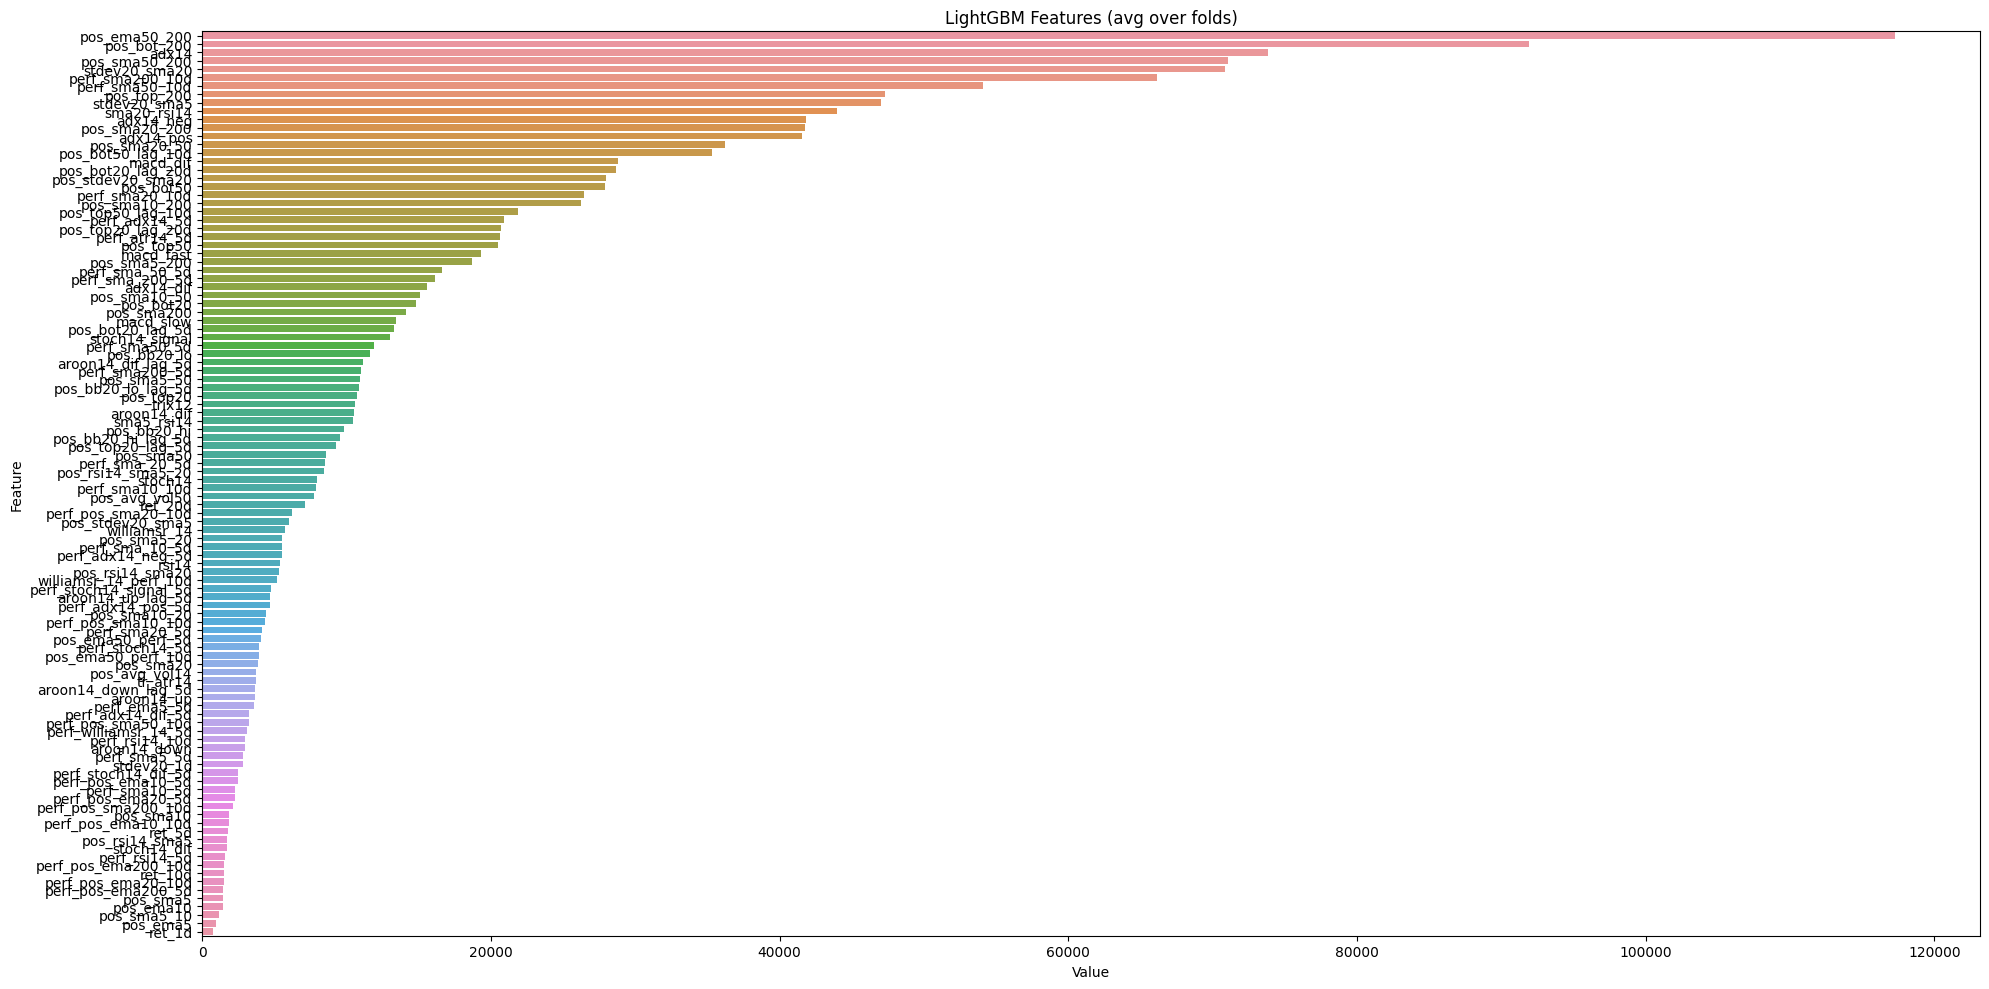

In [41]:
#  print the feature importance
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,df_x_train_r.columns)), columns=['Value','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

# save the feature importance in a file
feature_imp.to_csv(PATH_DATA_DTS+dts_name+"_LGBM_FEATURES_C.csv", sep=",")


In [ ]:
# print la map of the model
lgb.plot_importance(clf,importance_type='split',max_num_features=10,figsize=(20,10),title='Feature importance(split)')
lgb.plot_importance(clf,importance_type='gain',max_num_features=10,figsize=(20,10),title='Feature importance(gain)')
plt.show()


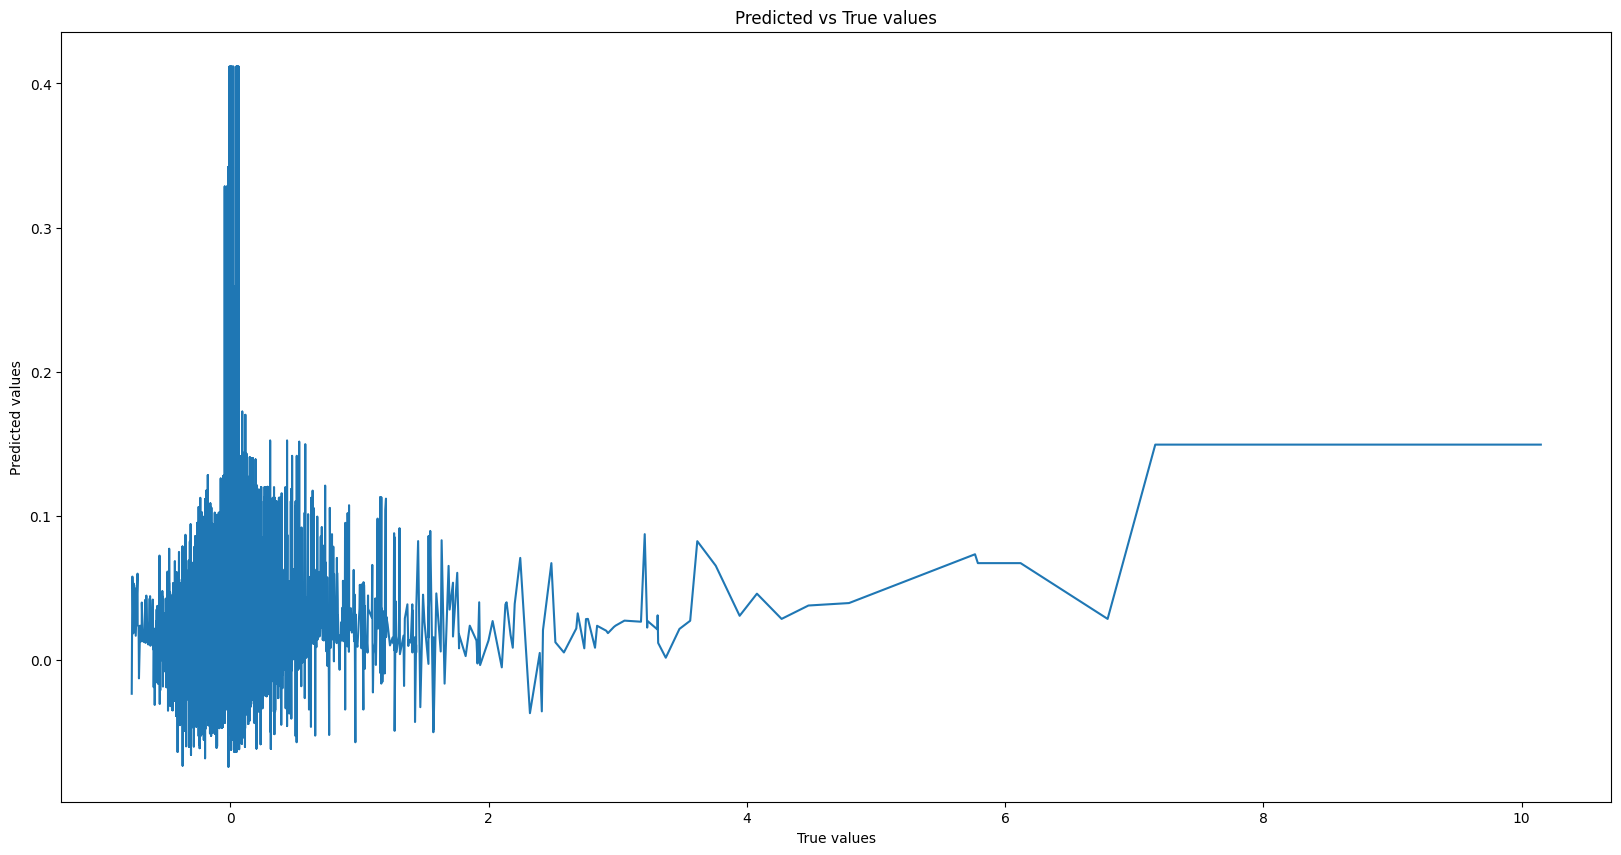

In [44]:
# for val dataset, plot the predicted values vs the true values, ordered by true values
df_val = df_x_val_r.copy()
df_val[label] = col_y_val
df_val['pred'] = clf.predict(df_x_val_r)
df_val.sort_values(by=label,inplace=True)
plt.figure(figsize=(20, 10))
plt.plot(df_val[label],df_val['pred'])
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Predicted vs True values')
plt.show()


In [ ]:
y_pred = clf.predict(df_x_train_r)
accuracy = accuracy_score(col_y_train, y_pred)
print(f'Accuracy Train: {accuracy}')


y_pred = clf.predict(df_x_val_r)
accuracy = accuracy_score(col_y_val, y_pred)
print(f'Accuracy Val: {accuracy}')
print(classification_report(col_y_val, y_pred))
# print the confusion matrix
print(metrics.confusion_matrix(col_y_val, y_pred))

In [ ]:

lgb.plot_importance(clf,max_num_features=40, figsize=(7,6), title="LightGBM Feature Importance")
plt.show()
# save features importance in a file
feature_imp=pd.DataFrame()
feature_imp['features']=df_x_train_r.columns
feature_imp['importance']=clf.feature_importances_
feature_imp.to_csv(PATH_DATA_DTS+dts_name+"_LGBM_FEATURE_IMPORTANCE.csv", sep=",")


In [8]:
# load the model PARIS_TREND_1D_20D_V3_LGBM_MODEL_R2.pkl and print the characteristics
clf = joblib.load(PATH_DATA_DTS+"PARIS_TREND_1D_20D_V3_LGBM_MODEL_R2.pkl")
print(clf)


LGBMClassifier(device_type='gpu', feature_fraction=0.8, lambda_l1=0.2,
               lambda_l2=0.2, learning_rate=0.01, max_depth=11,
               metric='multi_logloss', min_data_in_leaf=100, n_estimators=1000,
               num_class=5, num_leaves=511, objective='multiclass', seed=42,
               verbosity=-1)
